<a href="https://colab.research.google.com/github/olvad/DeepLearning_course/blob/main/DeepLearn_Texts_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>
<img src="https://raw.githubusercontent.com/dvgodoy/PyTorch101_ODSC_Europe2020/master/images/linear_dogs.jpg" width="800">

# Основы глубинного обучения: домашнее задание 4
</center>

**ФИО:** Кузнецов Вадим Олегович



## Общая информация

__Дата выдачи:__ 09.12.2023

__Дедлайн:__ 23:59MSK 18.12.2023

В случае этой домашки мягкий дедлан совпадает с жёстким.

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 5.2 балла (3 основных балла и ещё 2.2 бонусных).

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

In [ ]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# Описание данных

Данные можно [скачать с гугл-диска.](https://drive.google.com/drive/folders/11oCcLplWtp_qm-WuEbfCFP_Mz5K_z3ps?usp=sharing) Если вы делаете задание в колабе, то строчки ниже сами скачают вам данные.



In [ ]:
import gdown

url = "https://drive.google.com/drive/folders/1Tg0BCc1LbOCtNCy2mmkApIctrS-thjE7"
gdown.download_folder(url, quiet=True, use_cookies=False)

['/content/news_data/ria_news.tsv',
 '/content/news_data/vk_comments.tsv',
 '/content/news_data/vk_news.tsv']

В таблице `ria_news.tsv`  лежат данные о новостях, вышедших на сайте РИА-НОВОСТИ с 15 марта 2018 года по 31 декабря 2018 года.

- `href` - уникальный идентификатор новости (ссылка на неё)
- `date` - дата публикации новости
- `time` - время публикации новости
- `title` - заголовок новости
- `snippet` - краткое описание новости
- `text` - текст новости
- `category` - категория новости
- `keywords` - ключевые слова (подкатегории новости)
- `shows` - счётчик с числом просмотров новости на сайте (на момент парсинга)

In [ ]:
df_ria = pd.read_csv('news_data/ria_news.tsv', sep='\t')
df_ria = df_ria[~df_ria.tags.isnull()]
print(df_ria.shape)
df_ria.head()

(201708, 9)


,href,date,time,title,snippet,text,category,tags,shows
0,/20181231/1548961410.html,2018-12-31,"31 декабря 2018, 23:52",Нетаньяху не собирается в отставку в случае пр...,Премьер-министр Израиля Биньямин Нетаньяху не ...,"МОСКВА, 31 дек - РИА Новости. Премьер-министр ...",В мире,"Биньямин Нетаньяху, Израиль, В мире",728.0
1,/20181231/1548961364.html,2018-12-31,"31 декабря 2018, 23:19",Макрон в новогоднем обращении затронул тему ре...,"Результат реформ не может быть мгновенным, зая...","ПАРИЖ, 31 дек – РИА Новости. Результат реформ ...",В мире,"Эммануэль Макрон, Франция, В мире",3086.0
2,/20181231/1548961337.html,2018-12-31,"31 декабря 2018, 23:12",Аарон Рэмзи проведет переговоры с пятью топ-кл...,"Полузащитник лондонского ""Арсенала"" Аарон Рэмз...","МОСКВА, 31 дек - РИА Новости. Полузащитник лон...",NaN,ФК Арсенал (Лондон),183.0
3,/20181231/1548961304.html,2018-12-31,"31 декабря 2018, 23:09",Гол Азмуна принес сборной Ирана победу над кат...,Футболисты сборной Ирана одержали победу над к...,"МОСКВА, 31 дек - РИА Новости. Футболисты сборн...",NaN,"Сердар Азмун, Сборная Ирана по футболу",78.0
4,/20181231/1548961265.html,2018-12-31,"31 декабря 2018, 23:07",Пятая ракетка мира дель Потро пропустит Открыт...,Аргентинский теннисист Хуан Мартин дель Потро ...,"МОСКВА, 31 дек - РИА Новости. Аргентинский тен...",NaN,Теннис,79.0


Многие новостные агенства поддерживают странички в социальных сетях. Они постят туда самые сочные сюжеты. В таблице `vk_news.tsv` лежат данные о новостях, которые РИА запостили ВКонтакте в период времени с  `2017-09-29 01:28:55` по `2019-02-01 23:13:17`.

- `id` - уникальный идентификатор поста
- `href` - ссылка на сайт (если она была указана в посте)
- `datetime` - дата и время публикации новости
- `title` - заголовок новости
- `text` - текст новости в социальной сети
- `likes` - число лайков под постом
- `comments` - число комментариев под постом

In [ ]:
df_vk = pd.read_csv('news_data/vk_news.tsv', sep='\t')
df_vk['snippet'] = df_vk['text']
df_vk.drop('text', axis=1, inplace=True)
print(df_vk.shape)
df_vk.head()

(19928, 7)


,id,href,datetime,title,likes,comments,snippet
0,24006362,/20190201/1550280358.html,2019-02-01 23:13:17,"В ДНР заявили о задержании диверсантов, причас...",15,28,NaN
1,24006240,/20190201/1550268781.html,2019-02-01 22:38:41,"Житель Урала ""заминировал"" ТЦ из-за снятия со...",32,42,NaN
2,24006100,/20190201/1550282212.html,2019-02-01 21:58:52,"В Черном море нашли ""потерянный флот Гитлера""",84,23,NaN
3,24005972,/20190202/1550283179.html,2019-02-01 21:27:06,В США освободили задержанную российскую актрис...,58,35,NaN
4,24005764,/20190201/1550262848.html,2019-02-01 20:55:54,Толкнувший Скабееву депутат Рады заявил о гроз...,45,145,NaN


В таблице `vk_comments.tsv` лежат комментарии к новостям.

- `id` - уникальный идентификатор комментария
- `post_id` - идентификатор новости, под которой был оставлен комментарий
- `datetime` - дата и время, когда был оставлен комментарий
- `text` - текст комментария
- `likes` - число лайков под комментарием

In [ ]:
df_comments = pd.read_csv('news_data/vk_comments.tsv', sep='\t')
df_comments = df_comments[~df_comments.text.isnull()]
print(df_comments.shape)
df_comments.head()

<ipython-input-10-9f937a17e540>:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_comments = pd.read_csv('news_data/vk_comments.tsv', sep='\t')


(2612629, 5)


,id,post_id,datetime,text,likes
0,24006366.0,24006362.0,2019-02-01 23:14:14,ЧВК Вагнера?,5.0
1,24006370.0,24006362.0,2019-02-01 23:15:23,"[id4710641|Евгений], выздоравливай.",3.0
2,24006371.0,24006362.0,2019-02-01 23:16:21,"[id442655034|Андрей], искренне желаю этого все...",4.0
3,24006374.0,24006362.0,2019-02-01 23:16:38,Опять про Украину новости?,1.0
4,24006375.0,24006362.0,2019-02-01 23:16:40,Че такое ДНР?,2.0


# А что надо сделать то?

В тетрадке вам предстоит сделать следующие шаги:

1. Вы обучите нейросеть предсказывать категорию новости
2. Вы построите предсказания для тех новостей, где мы ничего не знаем о категории
3. Вы используете уже обученный для сентимент-анализа классификатор из библиотеки `hugging face` чтобы предсказать эмоциональную окраску каждого комментария
4. Вы проведёте аналитику по новостям, а именно построите топы из самых позитивных и негативных категорий и новостей

Для первого шага вам будет дан бэйзлайн. Если вы его прогоните, у вас получится базовая модель, которая даст некоторое качество решения задачи. Вам надо будет выяснить, насколько это качество оказалось хорошим, а затем внести в код некоторые улучшения.



## Часть 1: категоризация новостей (1.2 + 2 бонусных балла)

Каждой новости в соотвествие поставлены ключевые слова. Будем считать, что эти ключевые слова — тематики новости. Нужно научиться предсказывать тематики по тексту новости. Готовые тематики у нас есть только по новостям с сайта. Они за 2018 год. По новостям из ВКонтакте у нас тематик нет. Мы собираемся их предсказать.

Новости, опубликованные ВКонтакте, отличаются от новостей с сайта тем, что у них есть только титул и короткое описание. Странно будет обучать нейросеть на длинных текстах, а потом использовать её на коротких описаниях. Мы не будем так делать. Мы попробуем обучить базовый вариант нейронной сети только на заголовках новостей. Все, кто захочет получить бонусные баллы, смогут попробовать добавить в нейросеть сниппеты (так назыают короткие описания новостей).

## 1.1 Подготовка таргета

Поработаем с таргетом. Мы будем предсказывать переменную `tags`. Давайте выясним скоько уникальных тегов существует.

In [ ]:
from collections import Counter

# удалим все лишние пробелы и сделаем lowercase
df_ria['tags'] = (
    df_ria.tags.
    apply(lambda w: ','.join([item.strip() for item in  w.lower().split(',')]))
)

tags = ','.join(list(df_ria.tags.values))
tags_cnt = Counter(tags.split(','))

print(len(tags_cnt))
tags_cnt.most_common()[-20:]

13344


[('блог анны завершинской об автоспорте - блоги', 1),
 ('министерство транспорта рб', 1),
 ('министерство здравоохранения грузии', 1),
 ('палех', 1),
 ('юрий посохов (хореограф)', 1),
 ('мария александрова', 1),
 ('том бенсон', 1),
 ('абдул каюм кочай', 1),
 ('нуман куртулмуш', 1),
 ('mipim', 1),
 ('владимир попов', 1),
 ('брюно женезио', 1),
 ('роберт фицо', 1),
 ('сергей пашинский', 1),
 ('валерия гонтарева', 1),
 ('нововоронеж', 1),
 ('императорское православное палестинское общество', 1),
 ('event_poslanie_prezidenta_rf_federalnomu_sobraniju', 1),
 ('фхтр', 1),
 ('игорь честин', 1)]

Всего в выборке есть порядка 13 000 тэгов. Многие встречаются всего по разу. Давайте оставим в выборке только те тэги, которые встречаются более 30 раз.

In [ ]:
target_tags = {tag for tag,cnt in tags_cnt.most_common() if cnt > 30}
len(target_tags)

1583

Закодируем теги для OHE.

In [ ]:
tag2idx = dict(zip(target_tags, range(len(target_tags))))
idx2tag = {jtem: item for item,jtem in tag2idx.items()}

Почистим таргет от лишних тэгов.

In [ ]:
df_ria['target_tags'] = (
    df_ria.tags.
    apply(lambda w: [tag2idx.get(item) for item in  w.split(',') if item in target_tags])
)

df_ria = df_ria[df_ria.target_tags.apply(len) > 0]
df_ria.shape

(201437, 10)

In [ ]:
df_ria.target_tags.values[:3]

array([list([514, 1264, 1297]), list([1566, 1485, 1297]), list([612])],
      dtype=object)

## 1.2 Подготовка текстов

Теперь займёмся предобработкой текстов. Приведём все слова к маленькому регистру и выбросим мусорные символы. В качестве токенов будем рассматривать отдельные слова.

Напомню, что мы пока что решили работать только с названиями статей. Поэтому вся предобработка применяется исключительно к ним. **Спойлер:** предобработку для сниппетов вы сделаете сами в первом же задании.

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import re
from nltk.tokenize import word_tokenize

def normalise_text(text):
    text = text.lower()

    # сурово регулярками выкидываем мусорные символы
    text = re.sub('[^а-яa-z0-9 ]', '', text)
    return text.strip()

df_ria['title_clean'] = df_ria.title.apply(normalise_text)

word_cnt = Counter(word_tokenize(' '.join(df_ria.title_clean.values)))
len(word_cnt)

112178

In [ ]:
df_ria['title_clean']

0         нетаньяху не собирается в отставку в случае пр...
1         макрон в новогоднем обращении затронул тему ре...
4         пятая ракетка мира дель потро пропустит открыт...
5         сми кевину спейси не разрешили отсутствовать н...
6         зимняя классика нхл в 2020 году пройдет в далл...
                                ...                        
201792    газпром выделит 225 млрд рублей на газопроводы...
201793    столтенберг проведет встречу с джонсоном по де...
201794    строившийся 10 лет тц лухмановский в москве сд...
201795    британские военные смогут поставить прививку о...
201796    британский парламент может рассмотреть резолюц...
Name: title_clean, Length: 201437, dtype: object

In [ ]:
df_ria['title']

0         Нетаньяху не собирается в отставку в случае пр...
1         Макрон в новогоднем обращении затронул тему ре...
4         Пятая ракетка мира дель Потро пропустит Открыт...
5         СМИ: Кевину Спейси не разрешили отсутствовать ...
6         "Зимняя классика" НХЛ в 2020 году пройдет в Да...
                                ...                        
201792    "Газпром" выделит 22,5 млрд рублей на газопров...
201793    Столтенберг проведет встречу с Джонсоном по "д...
201794    Строившийся 10 лет ТЦ "Лухмановский" в Москве ...
201795    Британские военные смогут поставить прививку о...
201796    Британский парламент может рассмотреть резолюц...
Name: title, Length: 201437, dtype: object

In [ ]:
word_cnt.most_common()[:10]

[('в', 127323),
 ('на', 44386),
 ('с', 26150),
 ('и', 21771),
 ('о', 19948),
 ('по', 17014),
 ('россии', 13494),
 ('не', 13483),
 ('сша', 9942),
 ('за', 9881)]

Давайте почистим словарь от стоп-слов и подготовим его к использованию внутри датасета. Мы будем с помощью словаря заменять слова на индексы. Добавим в словарь несколько специальных токенов для неизвестных слов и паддингов.

In [ ]:
from nltk.corpus import stopwords

stops_ru = set(stopwords.words('russian'))
len(stops_ru)

151

In [ ]:
vocabulary = {
    "#PAD#": 0, "#UNK#": 1
}

k = 2
for word, _ in word_cnt.most_common():
    if word not in stops_ru:
        vocabulary[word] = k
        k += 1

In [ ]:
len(vocabulary)

112030

Завернём код для создания словаря в функцию.

In [ ]:
def create_vocab(text, stops_ru=stops_ru):

    word_cnt = Counter(word_tokenize(text))
    vocabulary = {
        "#PAD#": 0, "#UNK#": 1
    }

    k = 2
    for word, _ in word_cnt.most_common():
        if word not in stops_ru:
            vocabulary[word] = k
            k += 1
    return vocabulary

__[0.2 балла] Задание 1:__

- Cделайте аналогичную предобработку титулов из таблички `df_vk`. Запишите получившийся результат в столбец `title_clean` по аналогии с таблицей `df_ria`.
- Сделайте для обеих таблиц предобработку колонок со сниппетами `snippet` и запишите получившийся результат в столбец `snippet_clean`. Все пропуски заполните токеном `"#UNKN"`.

In [ ]:
df_vk['title'] = df_vk['title'].fillna("#UNK#")
df_vk['snippet'] = df_vk['snippet'].fillna("#UNK#")
df_ria['snippet'] = df_ria['snippet'].fillna("#UNK#")

df_vk['title_clean'] = df_vk['title'].apply(normalise_text)
df_vk['snippet_clean'] = df_vk['snippet'].apply(normalise_text)
df_ria['snippet_clean'] = df_ria.snippet.apply(normalise_text)

In [ ]:
df_vk['snippet'].isnull().sum()

0

## 1.3 Поставка данных

Пересечение сайта и ВК по опубликованным новостям довольно маленькое. Мы обучаем модель на данных с сайта. Предсказания мы будем строить на данных из ВК. У этих данных разная природа. В ВК описание статей и заголовки короче. Модель может хорошо показать себя на данных с новостного сайта, но сильно просесть в качестве на данных из ВК.

Давайте сохраним пересечение в отдельную табличку, чтобы на нём можно было понять, насколько сильно деградирует модель.

In [ ]:
ria_hrefs = set(df_ria.href.values)
vk_hrefs = set(df_vk.href.values)
test_hrefs = (vk_hrefs & ria_hrefs)

print('Размер отложенной выборки:', len(test_hrefs))

df = df_ria[~df_ria.href.isin(test_hrefs)]

Размер отложенной выборки: 1128


По странному совпадению (я правда не знаю почему) пересечение лежит в декабре. Мы будем его использовать как тестовую выборку.

In [ ]:
df_ria[df_ria.href.isin(test_hrefs)].date.min(), df_ria[df_ria.href.isin(test_hrefs)].date.max()

('2018-12-06', '2018-12-31')

Предположим, что мы делим выборку на обучающую и тестовую случайно. За один и тот же промежуток времени может выйти довольно большое число новостей с одинаковым заголовком. Давайте представим себе, что в тесте и трэйне есть много статей про одно и то же событие. Модель научилась на обучающей выборке хорошо его тегировать. Остальные события модель тегирует намного хуже. Метрики на тестовой выборке высокие. В следующем месяце СМИ перестают освещать это событие, в потоке новостей совершенно другие новости. Качество модели резко проседает.

Чтобы не напороться на завышенные метрики, обычно выборку дробят на обучающую и тестовую по времени. Тогда статьи из теста будут имитировать поток новых новостей, освещающих новые события.

In [ ]:
df.date.min(), df.date.max()

('2018-03-15', '2018-12-31')

__[0.2 балла] Задание 2:__ Разбейте выборку на обучающую, валидационную и тестовую. В тест возьмите весь декабрь. В валидацию октябрь и ноябрь.

In [ ]:
df

,href,date,time,title,snippet,text,category,tags,shows,target_tags,title_clean,snippet_clean
0,/20181231/1548961410.html,2018-12-31,"31 декабря 2018, 23:52",Нетаньяху не собирается в отставку в случае пр...,Премьер-министр Израиля Биньямин Нетаньяху не ...,"МОСКВА, 31 дек - РИА Новости. Премьер-министр ...",В мире,"биньямин нетаньяху,израиль,в мире",728.0,"[514, 1264, 1297]",нетаньяху не собирается в отставку в случае пр...,премьерминистр израиля биньямин нетаньяху не н...
1,/20181231/1548961364.html,2018-12-31,"31 декабря 2018, 23:19",Макрон в новогоднем обращении затронул тему ре...,"Результат реформ не может быть мгновенным, зая...","ПАРИЖ, 31 дек – РИА Новости. Результат реформ ...",В мире,"эммануэль макрон,франция,в мире",3086.0,"[1566, 1485, 1297]",макрон в новогоднем обращении затронул тему ре...,результат реформ не может быть мгновенным заяв...
4,/20181231/1548961265.html,2018-12-31,"31 декабря 2018, 23:07",Пятая ракетка мира дель Потро пропустит Открыт...,Аргентинский теннисист Хуан Мартин дель Потро ...,"МОСКВА, 31 дек - РИА Новости. Аргентинский тен...",NaN,теннис,79.0,[612],пятая ракетка мира дель потро пропустит открыт...,аргентинский теннисист хуан мартин дель потро ...
5,/20181231/1548961218.html,2018-12-31,"31 декабря 2018, 23:06",СМИ: Кевину Спейси не разрешили отсутствовать ...,Суд в американском штате Массачусетс отверг хо...,"МОСКВА, 31 дек - РИА Новости. Суд в американск...",В мире,"кевин спейси,сша,в мире",2058.0,"[849, 1297]",сми кевину спейси не разрешили отсутствовать н...,суд в американском штате массачусетс отверг хо...
6,/20181231/1548961194.html,2018-12-31,"31 декабря 2018, 23:06","""Зимняя классика"" НХЛ в 2020 году пройдет в Да...","""Зимняя классика"" - матч регулярного чемпионат...","МОСКВА, 31 дек - РИА Новости. ""Зимняя классика...",NaN,"нхл,хоккей",89.0,"[1033, 1012]",зимняя классика нхл в 2020 году пройдет в далл...,зимняя классика матч регулярного чемпионата н...
...,...,...,...,...,...,...,...,...,...,...,...,...
201792,/20180315/1517454702.html,2018-03-15,"15 марта 2018, 14:48","""Газпром"" выделит 22,5 млрд рублей на газопров...","<p><strong>МОСКВА, 15 мар — РИА Новости.</str...","МОСКВА, 15 мар — РИА Новости. Председатель пра...",Экономика,"газпром,вологодская область,экономика",12.0,"[1095, 371, 696]",газпром выделит 225 млрд рублей на газопроводы...,pstrongмосква 15 мар риа новостиstrong председ...
201793,/20180315/1516435453.html,2018-03-15,"15 марта 2018, 14:48","Столтенберг проведет встречу с Джонсоном по ""д...","<p><strong>БРЮССЕЛЬ, 15 мар — РИА Новости.</s...","БРЮССЕЛЬ, 15 мар — РИА Новости. НАТО готова ок...",В мире,"дело об отравлении скрипалей,нато,великобритан...",584.0,"[1054, 360, 1178, 1297]",столтенберг проведет встречу с джонсоном по де...,pstrongбрюссель 15 мар риа новостиstrong нато ...
201794,/20180315/1516435219.html,2018-03-15,"15 марта 2018, 14:47","Строившийся 10 лет ТЦ ""Лухмановский"" в Москве ...",В московском районе Кожухово сдали в эксплуата...,"МОСКВА, 15 мар — РИА Недвижимость. В московско...",Недвижимость,"долгострой,коммерческая недвижимость,москва,ро...",589.0,"[6, 861, 578, 973, 809, 1056]",строившийся 10 лет тц лухмановский в москве сд...,в московском районе кожухово сдали в эксплуата...
201795,/20180315/1516435313.html,2018-03-15,"15 марта 2018, 14:47",Британские военные смогут поставить прививку о...,"<p><strong></strong></p>\n<p><strong>ЛОНДОН, ...","\nЛОНДОН, 15 мар — РИА Новости, Мария Табак. Б...",В мире,"великобритания,в мире",471.0,"[1178, 1297]",британские военные смогут поставить прививку о...,pstrongstrongppstrongлондон 15 мар риа новости...


In [ ]:
# your code here
# ♡ (´｡• ω •｡`)
df['date'] = pd.to_datetime(df['date'])

df_test = df[df['date'].dt.month == 12]
df_val = df[(df['date'].dt.month >= 10) & (df['date'].dt.month <= 11)]
df_train = df[df['date'].dt.month < 10]

<ipython-input-31-f41ffe236e9e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])


Сформируем отложенную выборку (пересечение ВКонтакте и РИА).

In [ ]:
df_oob = df_vk[df_vk.href.isin(test_hrefs)][['href', 'title_clean']]

df_ria_oob = df_ria[df_ria.href.isin(test_hrefs)][['href', 'target_tags']]
df_oob = df_oob.set_index('href').join(df_ria_oob.set_index('href')).reset_index()
df_oob.head()

,href,title_clean,target_tags
0,/20181206/1547493936.html,эксперты определили самые бюджетные экзотическ...,"[1374, 965]"
1,/20181206/1547516457.html,рада приняла закон расширяющий контролируемую ...,"[1506, 1297]"
2,/20181206/1547520788.html,россия оказалась родиной древнейших титанозавр...,"[1100, 980]"
3,/20181206/1547521406.html,школа в красноярске превратилась в хогвартс из...,[792]
4,/20181206/1547522342.html,рада решила не продлевать договор о дружбе и с...,"[1382, 1297]"


Напишем датасет для поставки данных в нейросеть.


In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class NewsDataset(Dataset):

    def __init__(self, target, title, vocab, vocab_size, max_title_len, max_classes, snippet=None, max_snippet_len=None):

       self.vocab = {word: idx  for word,idx in vocab.items() if idx < vocab_size}
       self.max_classes = max_classes
       self.y=self.target_ohe(target)
       self.X_title = self.create_text(title, max_title_len)
       self.snippet = snippet
       if snippet is not None:
        self.X_snippet = self.create_text(snippet, max_snippet_len)

    def target_ohe(self, target):
        y = torch.zeros((len(target), self.max_classes))
        for i, t in enumerate(target):
            y[[i]*len(t), t] = 1.0
        return y

    def create_text(self, texts, max_len):
        result = [ ]
        for sent in texts:
            # {#PAD: 0, #UNKN: 1}
            sent_tokenize = [self.vocab.get(item, 1) for item in word_tokenize(sent)]

            # приводим все тексты к max_len
            if len(sent_tokenize) >= max_len:
                sent_tokenize = sent_tokenize[:max_len]
            else:
                sent_tokenize += [0] * (max_len - len(sent_tokenize))
            result.append(sent_tokenize)
        return torch.tensor(result, dtype=torch.int)

    def __len__(self):
        return len(self.X_title)

    def __getitem__(self, idx):
      if self.snippet is None:
        return (self.X_title[idx, :], self.y[idx])
      else:
         return (self.X_title[idx, :], self.X_snippet[idx, :], self.y[idx])

__[0.2 балла] Задание 3:__ Сейчас датасет умеет работать только с полем `title_clean`. Давайте сделаем этот датасет более многофукнциональным и добавим в него возможность добавить в обработку данных сниппет.

1. Внутри датасета `snippet` надо обработать точно также как и `title`.
2. Если `snippet=None`, датасет должен вернуть два объекта: `X_title, y`. В обратном случае датасет должен вернуть три объекта.

**Важно:** Весь код ниже работает сейчас без сниппета. Он не должен развалиться от того, что сниппет в нём нигде не указан.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you

# Внесите в код датасета выше свои правки

Объявим датасеты, оставим в словаре 30 000 самых частотных слов. Будем смотреть на титулы максимальной длины 20.

In [ ]:
CLASSES_NUM = len(idx2tag)
VOCAB_SIZE = 10000
MAX_TITLE_LEN = 20

# словарь создаем по всей выборке
vocabulary = create_vocab(' '.join(df_ria.title_clean.values))

# объявляем датасеты
train_dataset = NewsDataset(df_train.target_tags.values, df_train.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM )
val_dataset = NewsDataset(df_val.target_tags.values, df_val.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM )
test_dataset = NewsDataset(df_test.target_tags.values, df_test.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM )

In [ ]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=64, num_workers=4)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=4096, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## 1.4 Архитектуры

Соберём базовую архитектуру для обучения.

In [ ]:
from torch import nn
import torch.nn.functional as F

class SimpleClassifier(nn.Module):

    def __init__(self, vocab_size, embedding_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, title):
        embedded = self.embedding(title)
        embedded = embedded.mean(dim=1)
        return self.fc(embedded)

Соберём в `pytorch_lightning` модуль для обучения нейронки.

In [ ]:
!pip3 install pytorch_lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 34.2 MB/s eta 0:00:00


In [ ]:
import pytorch_lightning as pl

class TrainLightningModule(pl.LightningModule):
    def __init__(self, model, learning_rate, criterion):
        super().__init__()
        self.model = model
        self.criterion = criterion
        self.learning_rate = learning_rate

    def forward(self, title):
        result = self.model(title)
        return result

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        title, target = train_batch
        logits = self.model(title)
        loss = self.criterion(logits, target)
        self.log(
            "train_loss", loss, prog_bar=True
        )
        return loss

    def validation_step(self, val_batch, batch_idx):
        title, target = val_batch
        logits = self.model(title)
        loss = self.criterion(logits, target)
        self.log(
            "val_loss", loss, prog_bar=True
        )
        return loss

Обучим модель.

In [ ]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.0 MB/s eta 0:00:00


In [ ]:
import wandb

wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
from pytorch_lightning.loggers import WandbLogger

EMBEDDING_DIM = 100 # Уменьшил из-за озу
EPOCHS = 5
LR = 1e-3
wandb_logger = WandbLogger(log_model='all')
model_baseline = SimpleClassifier(VOCAB_SIZE, EMBEDDING_DIM, CLASSES_NUM)
criterion = torch.nn.CrossEntropyLoss()

train_module =TrainLightningModule(model_baseline, LR, criterion)

trainer = pl.Trainer(accelerator="gpu", max_epochs=EPOCHS, logger=wandb_logger)
trainer.fit(train_module, train_dataloader, val_dataloader)
wandb.finish()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
wandb: Currently logged in as: olvad (iaddl). Use `wandb login --relogin` to force relogin


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params
-----------------------------------------------
0 | model     | SimpleClassifier | 1.2 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.640     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
train_loss,█▆▆▇▆▆▅▅▅▆▃▄▃▆▅▄▄▃▃▄▃▃▁▂▃▄▁▄▃▃▃▃▂▂▁▁▂▂▁▃
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▅▃▂▁
epoch,4
train_loss,10.48741
trainer/global_step,10694
val_loss,11.86062


https://api.wandb.ai/links/iaddl/53dmmnh1

__[0.2 балла] Задание 4:__  Модель выше работает только с титулом.

- Залоггируйте её обучение на [WandB](https://wandb.ai/).
- Соберите архитектуру, которая будет принимать на вход не только титул, но ещё и сниппет. В этой архитектуре должно происходить следующее:

1. Общий слой `nn.Embedding` применяется к сниппету и титулу параллельно.
2. Происходит усреднее по текстам.
3. Вектора конкатятся в один длины 600
4. Линейный слой делает классификацию

Обучите эту модель. Сравните траектории обучения на WandB. Прикрепите ссылку на дашборд либо скришот к тетрадке.

Даталоадеры придётся объявить заново с учётом сниппетов. Правда ли, что она бьёт на валидационной выборке модель, обученную только на титулах статей?

In [ ]:
class Architecturaaa(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc = nn.Linear(embedding_dim * 2, output_dim)

    def forward(self, title, snippet):
        embedded_title = self.embedding(title).mean(dim=1)
        embedded_snippet = self.embedding(snippet).mean(dim=1)
        combined = torch.cat((embedded_title, embedded_snippet), dim=1)
        return self.fc(combined)

In [ ]:
df_train

,href,date,time,title,snippet,text,category,tags,shows,target_tags,title_clean,snippet_clean
64835,/20180930/1529669120.html,2018-09-30,"30 сентября 2018, 23:59",Обвинившую Кавано в домогательствах американку...,<p><strong></strong></p>\n<p><strong>ВАШИНГТО...,"\nВАШИНГТОН, 30 сен — РИА Новости. Обвинившая ...",В мире,"сша,в мире",3372.0,"[849, 1297]",обвинившую кавано в домогательствах американку...,pstrongstrongppstrongвашингтон 30 сен риа ново...
64836,/20180930/1529669084.html,2018-09-30,"30 сентября 2018, 23:57",Полиция сообщила об обстановке в башкирском се...,"<p><strong>УФА, 30 сен – РИА Новости.</strong...","УФА, 30 сен – РИА Новости. В Баймакском районе...",Происшествия,"республика башкортостан,происшествия",6345.0,"[1011, 1355]",полиция сообщила об обстановке в башкирском се...,pstrongуфа 30 сен риа новостиstrong в баймакс...
64837,/20180930/1142994754.html,2018-09-30,"30 сентября 2018, 23:55","Червиченко: ""Зенит"" в матче с ""Анжи"" подвели д...","""Зенит"" в воскресенье на выезде уступил ""Анжи""...","\nС.-ПЕТЕРБУРГ, 30 сен - РИА Новости, Тарас Ба...",Спорт,"андрей червиченко,спорт,футбол",2.0,"[854, 99]",червиченко зенит в матче с анжи подвели две ду...,зенит в воскресенье на выезде уступил анжи в м...
64838,/20180930/1529669017.html,2018-09-30,"30 сентября 2018, 23:51",Франция готова помочь Индонезии после землетря...,"<p><strong></strong></p>\n<p><strong>ПАРИЖ, 3...","\nПАРИЖ, 30 сен — РИА Новости, Виктория Иванов...",В мире,"землетрясение в индонезии,индонезия,в мире",442.0,"[293, 367, 1297]",франция готова помочь индонезии после землетря...,pstrongstrongppstrongпариж 30 сен риа новости ...
64839,/20180930/1529668973.html,2018-09-30,"30 сентября 2018, 23:49",В Иране троих человек приговорили к смертной к...,"<p><strong></strong></p>\n<p><strong>МОСКВА, ...","\nМОСКВА, 30 сен — РИА Новости. Трех человек п...",В мире,"иран,в мире",754.0,"[1188, 1297]",в иране троих человек приговорили к смертной к...,pstrongstrongppstrongмосква 30 сен риа новости...
...,...,...,...,...,...,...,...,...,...,...,...,...
201792,/20180315/1517454702.html,2018-03-15,"15 марта 2018, 14:48","""Газпром"" выделит 22,5 млрд рублей на газопров...","<p><strong>МОСКВА, 15 мар — РИА Новости.</str...","МОСКВА, 15 мар — РИА Новости. Председатель пра...",Экономика,"газпром,вологодская область,экономика",12.0,"[1095, 371, 696]",газпром выделит 225 млрд рублей на газопроводы...,pstrongмосква 15 мар риа новостиstrong председ...
201793,/20180315/1516435453.html,2018-03-15,"15 марта 2018, 14:48","Столтенберг проведет встречу с Джонсоном по ""д...","<p><strong>БРЮССЕЛЬ, 15 мар — РИА Новости.</s...","БРЮССЕЛЬ, 15 мар — РИА Новости. НАТО готова ок...",В мире,"дело об отравлении скрипалей,нато,великобритан...",584.0,"[1054, 360, 1178, 1297]",столтенберг проведет встречу с джонсоном по де...,pstrongбрюссель 15 мар риа новостиstrong нато ...
201794,/20180315/1516435219.html,2018-03-15,"15 марта 2018, 14:47","Строившийся 10 лет ТЦ ""Лухмановский"" в Москве ...",В московском районе Кожухово сдали в эксплуата...,"МОСКВА, 15 мар — РИА Недвижимость. В московско...",Недвижимость,"долгострой,коммерческая недвижимость,москва,ро...",589.0,"[6, 861, 578, 973, 809, 1056]",строившийся 10 лет тц лухмановский в москве сд...,в московском районе кожухово сдали в эксплуата...
201795,/20180315/1516435313.html,2018-03-15,"15 марта 2018, 14:47",Британские военные смогут поставить прививку о...,"<p><strong></strong></p>\n<p><strong>ЛОНДОН, ...","\nЛОНДОН, 15 мар — РИА Новости, Мария Табак. Б...",В мире,"великобритания,в мире",471.0,"[1178, 1297]",британские военные смогут поставить прививку о...,pstrongstrongppstrongлондон 15 мар риа новости...


In [ ]:
CLASSES_NUM = len(idx2tag)
VOCAB_SIZE = 10000
MAX_TITLE_LEN = 20
MAX_SNIPPET_LEN = 20


vocabulary = create_vocab(' '.join(df_ria.title_clean.values))


train_dataset2 = NewsDataset(df_train.target_tags.values, df_train.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM, snippet= df_train.snippet_clean.values, max_snippet_len = MAX_SNIPPET_LEN  )
val_dataset2 = NewsDataset(df_val.target_tags.values, df_val.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM, snippet= df_val.snippet_clean.values, max_snippet_len = MAX_SNIPPET_LEN  )
test_dataset2 = NewsDataset(df_test.target_tags.values, df_test.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM, snippet= df_test.snippet_clean.values, max_snippet_len = MAX_SNIPPET_LEN  )

In [ ]:
train_dataloader2 = DataLoader(train_dataset2, shuffle=True, batch_size=64, num_workers=4)
val_dataloader2 = DataLoader(val_dataset2, shuffle=False, batch_size=64, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
import pytorch_lightning as pl

class TrainLightningModule2(pl.LightningModule):
    def __init__(self, model, learning_rate, criterion):
        super().__init__()
        self.model = model
        self.criterion = criterion
        self.learning_rate = learning_rate

    def forward(self, title, snippet):
        result = self.model(title, snippet)
        return result

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        title, snippet, target = train_batch
        logits = self.model(title, snippet)
        loss = self.criterion(logits, target)
        self.log(
            "train_loss", loss, prog_bar=True
        )
        return loss

    def validation_step(self, val_batch, batch_idx):
        title, snippet, target = val_batch
        logits = self.model(title, snippet)
        loss = self.criterion(logits, target)
        self.log(
            "val_loss", loss, prog_bar=True
        )
        return loss

In [ ]:
EMBEDDING_DIM = 100
EPOCHS = 5
LR = 1e-3
wandb_logger = WandbLogger(log_model='all')
model_baseline2 = Architecturaaa(VOCAB_SIZE, EMBEDDING_DIM, CLASSES_NUM)
criterion = torch.nn.CrossEntropyLoss()

train_module =TrainLightningModule2(model_baseline2, LR, criterion)

trainer = pl.Trainer(accelerator="gpu", max_epochs=EPOCHS, logger=wandb_logger)
trainer.fit(train_module, train_dataloader2, val_dataloader2)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Architecturaaa   | 1.3 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.273     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


https://api.wandb.ai/links/iaddl/rp94eixf

## 1.5 Инференс и оценка качества моделей

Для каждой новости нам надо предсказывать несколько тэгов. То есть в нашем случае настоящее значение таргета это множество из тэгов $y_i = [tag1, tag2, tag3]$. Прогноз модели также множество из тэгов $\hat y_i = [tag1, tag4]$.

Будем считать метрики качества следующим образом (под $|A|$ имеется в виду мощность множества, то есть число элементов в нём):

$$
Precision = \frac{1}{n} \sum_{i = 1}^n \frac{|y_i \cap \hat{y}_i|}{|\hat{y}_i|}
$$

$$
Recall = \frac{1}{n} \sum_{i = 1}^n \frac{|y_i \cap \hat{y}_i|}{|y_i|}
$$

Также можно считать аналог Accuracy, но это не самая удачная идея, так как у нас в выборке огромное число нулей и эта метрика при любом разумном пороге для принятия решения будет очень высокой.

$$
Exact Match = \frac{1}{n} \cdot \frac{1}{k} \sum_{i = 1}^n \sum_{k=1}^K [y_{ij} = \hat{y}_{ij}]
$$

In [ ]:
def precision(target, y_pred):
    num = ((y_pred == 1) & (target == 1)).sum(dim=1)
    denum = (y_pred == 1).sum(dim=1)
    return (num/(denum + 1e-5)).mean().item()

def recall(target, y_pred):
    num = ((y_pred == 1) & (target == 1)).sum(dim=1)
    denum = (target == 1).sum(dim=1)
    return (num/(denum + 1e-5)).mean().item()

def exact_match(target, y_pred):
    return (1.*(y_pred == target)).mean().item()

Построим прогноз на тестовой выборке.

In [ ]:
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=test_dataset.__len__())

for title, target in test_dataloader:
    logit = model_baseline(title)
    pred_prob = F.softmax(logit, dim=1)

assert pred_prob.shape[0] == test_dataset.__len__()

Теперь выбирая различное значение порога, мы можем получать разные предсказания. Если взять очень большое значение порога, то метрики сильно просядут, так как во многих документах никакого прогноза не будет построено вообще.

In [ ]:
TRESHOLD = 0.01
y_pred = 1*(pred_prob > TRESHOLD)

print('Exact Match:', exact_match(target, y_pred))
print('Precision:', precision(target, y_pred))
print('Recall:', recall(target, y_pred))

Exact Match: 0.9950454831123352
Precision: 0.24287016689777374
Recall: 0.7062445878982544


In [ ]:
TRESHOLD = 0.05
y_pred = 1*(pred_prob > TRESHOLD)
print('Exact Match:', exact_match(target, y_pred))
print('Precision:', precision(target, y_pred))
print('Recall:', recall(target, y_pred))

Exact Match: 0.9982604384422302
Precision: 0.49473583698272705
Recall: 0.5354433059692383


In [ ]:
TRESHOLD = 0.9
y_pred = 1*(pred_prob > TRESHOLD)

print('Exact Match:', exact_match(target, y_pred))
print('Precision:', precision(target, y_pred))
print('Recall:', recall(target, y_pred))

Exact Match: 0.9983157515525818
Precision: 0.0015860269777476788
Recall: 0.0014414677862077951


Дальше мы будем строить довольно много прогнозов. Давайте напишем код для их строительства в виде функции. Обратите внимание, что на модели со снипетом она упадёт. Когда вы доберётесь до строительства прогнозов, функцию придётся немного модернизировать.

In [ ]:
def get_predict(model, dataset, snippet = False):
    dataloader = DataLoader(dataset, shuffle=False, batch_size=dataset.__len__())

    if snippet:
      for title, snippet, target in dataloader:
          logit = model(title, snippet)
          pred_prob = F.softmax(logit, dim=1)
    else:
      for title, target in dataloader:
          logit = model(title)
          pred_prob = F.softmax(logit, dim=1)

    assert pred_prob.shape[0] == dataset.__len__()
    return pred_prob, target

__[0.2 балла] Задание 5:__ Какая метрика для нас в этой задаче важнее? Точность или полнота? Почему?

__ваш ответ:__ Зависит от того, что мы хотим.

- Напишите функцию, которая будет подбирать оптимальное значение порога, оптимизирующее выбранную вами метрику.
- Подберите значение порога на валидационной выборке.
- Сравните модель со сниппетами и без сниппетов, используя выбранную вами метрику при оптимальном значении порога на тестовой выборке.
- Какая из них оказалась лучше?

In [ ]:
import numpy as np

def find_optimal_threshold(predictions, target, metric):
    thresholds = np.linspace(0, 1, 100)
    optimal_threshold = 0
    best_metric = 0
    for threshold in thresholds:
        y_pred = 1 * (predictions > threshold)
        current_metric = metric(target, y_pred)
        if current_metric > best_metric:
            best_metric = current_metric
            optimal_threshold = threshold
    return (optimal_threshold, best_metric)



# (＠_＠)

In [ ]:
snippet_prob, snippet_target = get_predict(model_baseline2, val_dataset2, snippet=True)
print(find_optimal_threshold(snippet_prob, snippet_target, precision))

(0.12121212121212122, 0.7198208570480347)


threshhold = 0.12

precision = 0.72

(Пусть будет написано лишний раз)

In [ ]:
prr, targ = get_predict(model_baseline, val_dataset, snippet=False)
print(find_optimal_threshold(prr, targ, precision))

(0.11111111111111112, 0.68641197681427)


threshhold = 0.11
precision = 0.68
(Пусть будет написано лишний раз)

Качество со сниппетом лучше

__[0.2 балла] Задание 6:__  Постройте прогнозы для отложенной выборки, которая представляет из себя пересечение сайта РИА-новостей и ВКонтакте. Проседает ли на ней качество модели? Насколько сильно?

In [ ]:
df_oob.head()

,href,title_clean,target_tags
0,/20181206/1547493936.html,эксперты определили самые бюджетные экзотическ...,"[842, 947]"
1,/20181206/1547516457.html,рада приняла закон расширяющий контролируемую ...,"[55, 940]"
2,/20181206/1547520788.html,россия оказалась родиной древнейших титанозавр...,"[1169, 1533]"
3,/20181206/1547521406.html,школа в красноярске превратилась в хогвартс из...,[1369]
4,/20181206/1547522342.html,рада решила не продлевать договор о дружбе и с...,"[1358, 940]"


In [ ]:
oobN = NewsDataset(df_oob.target_tags.values, df_oob.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM )

probpred, target = get_predict(model_baseline, oobN, snippet = False)
probpred = 1 * (probpred > 0.11111111)

precision(target, probpred)

0.5180901288986206

Качество просело, прилично

__Ваш лог экспериментов:__

- Добавил много сверток - работало гораздо хуже, мб связано с тем, что информация теряется из-за них. Короче так себе идея.
- Последняя (ниже) модель неплохая, хотя на последней эпохе val_loss вверх пошел, короче странная это тема
- Но precision не подрос мальца, мб погрешность

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleArchitectura(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim, n_filters, kernel_sz):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)


        self.conv_title = nn.Conv1d(in_channels=embedding_dim, out_channels=n_filters, kernel_size=kernel_sz)
        self.conv_snippet = nn.Conv1d(in_channels=embedding_dim, out_channels=n_filters, kernel_size=kernel_sz)
        self.fc = nn.Linear(n_filters * 2, output_dim)
    def forward(self, title, snippet):

        embedded_title = self.embedding(title).permute(0, 2, 1)
        embedded_snippet = self.embedding(snippet).permute(0, 2, 1)


        conved_title = F.relu(self.conv_title(embedded_title))
        conved_snippet = F.relu(self.conv_snippet(embedded_snippet))

        conved_title, _ = conved_title.max(dim = -1)
        conved_snippet, _ = conved_snippet.max(dim = -1)

        combined = torch.cat((conved_title, conved_snippet), dim=1)


        return self.fc(combined)




In [ ]:
import pytorch_lightning as pl

class TrainLightningModule3(pl.LightningModule):
    def __init__(self, model, learning_rate, criterion):
        super().__init__()
        self.model = model
        self.criterion = criterion
        self.learning_rate = learning_rate

    def forward(self, title, snippet):
        result = self.model(title, snippet)
        return result

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        title, snippet, target = train_batch
        logits = self.model(title, snippet)
        loss = self.criterion(logits, target)
        self.log(
            "train_loss", loss, prog_bar=True
        )
        return loss

    def validation_step(self, val_batch, batch_idx):
        title, snippet, target = val_batch
        logits = self.model(title, snippet)
        loss = self.criterion(logits, target)
        self.log(
            "val_loss", loss, prog_bar=True
        )
        return loss

In [ ]:
EMBEDDING_DIM = 100
EPOCHS = 5
outs = 128
ks = 3
LR = 1e-3
run = wandb.init(project="project3arch")
wandb_logger2 = WandbLogger(log_model='all')
model_baseline3 = SimpleArchitectura(VOCAB_SIZE, EMBEDDING_DIM, CLASSES_NUM, outs, ks)
criterion = torch.nn.CrossEntropyLoss()

train_module =TrainLightningModule3(model_baseline3, LR, criterion)

trainer2 = pl.Trainer(accelerator="gpu", max_epochs=EPOCHS, logger=wandb_logger2)
trainer2.fit(train_module, train_dataloader2, val_dataloader2)
wandb.finish()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type               | Params
-------------------------------------------------
0 | model     | SimpleArchitectura | 1.5 M 
1 | criterion | CrossEntropyLoss   | 0     
-------------------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
5.936     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
train_loss,▇█▇▆▅▃▃▅▄▃▃▂▄▂▄▃▁▁▁▂▂▂▂▂▁▂▁▁▂▂▂▂▁▂▁▁▁▁▁▂
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▂▁▂▂
epoch,4
train_loss,6.2206
trainer/global_step,10694
val_loss,11.78004


https://api.wandb.ai/links/iaddl/99g0o6aw

In [ ]:
probpred, target = get_predict(model_baseline3, val_dataset2, snippet = True)

In [ ]:
probpred = 1 * (probpred > 0.12)

print(precision(target, probpred))

0.7162769436836243


Подобрал уже порог вручную, ОЗУ и так на нуле. Качество похуже
https://wandb.ai/iaddl/lightning_logs/reports/---Vmlldzo2MzA0MzE3 val_loss подрос в конце

__[0.5]__ Скачайте с сайта [Rusvectores](https://rusvectores.org/ru/models/) любые новостные word2vec эмбединги. Возьмите из модели эмбеддинги для всех слов, которые встречаются вв вашем словаре и добавьте их в модель первым слоем. Заморозьте этот слой и не обновляйте в нём веса. Если у вас в словаре есть слово, но его нет среди предобученных эмбеддингов, замените его на токен `#UNKN`.

__Ваш лог экспериментов:__

-
-
-

In [ ]:

# =^･ｪ･^=

{'#PAD#': 0,
 '#UNK#': 1,
 'россии': 2,
 'сша': 3,
 'заявил': 4,
 'москве': 5,
 'путин': 6,
 'матче': 7,
 'изза': 8,
 'сирии': 9,
 'рассказал': 10,
 'сми': 11,
 'россия': 12,
 'заявили': 13,
 'области': 14,
 'сборной': 15,
 'человек': 16,
 'мид': 17,
 'эксперт': 18,
 'назвал': 19,
 'против': 20,
 'рассказали': 21,
 'глава': 22,
 'чм': 23,
 'года': 24,
 'суд': 25,
 'году': 26,
 'трамп': 27,
 'чм2018': 28,
 'тысяч': 29,
 'мира': 30,
 'москвы': 31,
 'считает': 32,
 'рф': 33,
 'чемпионата': 34,
 'дтп': 35,
 'украине': 36,
 'прокомментировал': 37,
 'призвал': 38,
 'власти': 39,
 'тренер': 40,
 'украины': 41,
 'цска': 42,
 'выборах': 43,
 'оон': 44,
 'рублей': 45,
 'днр': 46,
 'дело': 47,
 'делу': 48,
 'матч': 49,
 'назвали': 50,
 'российские': 51,
 'путина': 52,
 'ес': 53,
 'сборная': 54,
 'погибли': 55,
 'источник': 56,
 'могут': 57,
 'кндр': 58,
 'российских': 59,
 'россию': 60,
 'порошенко': 61,
 'подмосковье': 62,
 'главы': 63,
 'трампа': 64,
 'время': 65,
 'число': 66,
 'европы': 67,
 

__[1 балл]__ Зафайнтьюньте трансформер для решения задачи с помощью библиотеки `hugging face`. Выбор предобученной модели кратко обоснуйте.

__Ваш лог экспериментов:__

-
-
-

In [ ]:
# your code here
# ٩(ˊ〇ˋ*)و


Сравните все обученные модели между собой на тестовой выборке.

In [ ]:
# your code here
# (⌐■_■)

## Часть 2: предсказание категорий (0.3 балла)

Возьмите датасет `df_vk` и для всех новостей из него предскажите категории с помощью лучшей, получившейся у вас модели.

In [ ]:
df_vk['target_tags'] = [[0]]*df_vk.shape[0]
vk_dff = NewsDataset(df_vk.target_tags.values, df_vk.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM, df_vk.snippet_clean.values, MAX_SNIPPET_LEN)
pred, target = get_predict(model_baseline2, vk_dff, snippet = True)

In [ ]:
pred

tensor([[6.4644e-07, 9.4918e-05, 5.6478e-06,  ..., 1.8490e-05, 4.3855e-04,
         1.1105e-04],
        [1.7327e-06, 2.6308e-05, 5.2176e-05,  ..., 1.1370e-05, 2.3609e-03,
         9.6795e-04],
        [7.5947e-07, 7.5530e-05, 6.7017e-06,  ..., 3.8198e-05, 3.6468e-04,
         1.5210e-04],
        ...,
        [2.5798e-06, 3.3178e-05, 1.2332e-05,  ..., 4.2281e-05, 1.0470e-03,
         8.2327e-04],
        [1.6540e-07, 9.0355e-05, 2.0511e-06,  ..., 1.0267e-05, 1.0289e-04,
         5.0336e-05],
        [1.4867e-06, 1.1299e-04, 1.8194e-05,  ..., 2.1882e-05, 1.1305e-03,
         7.4285e-04]], grad_fn=<SoftmaxBackward0>)

На всякий случай сохраните табличку с получившимися у вас предсказаниями. Мало ли, вы не доделаете последнее задание, а потом захотите вернуться к нему. Не прогонять же обучение нейросети и инференс по второму кругу...

In [ ]:
df_vk.to_csv('vk_predictions.csv', index=False)

# ¯\_(ツ)_/¯

In [ ]:
torch.save(pred, 'pred.pt')

In [ ]:
torch.save(target,'target.pt')

## Часть 3: сентимент-классификатор (0.5 балла)

В этой части тетрадки нам предстоит прогнать все комментарии из ВК через сентимент-классификатор. Мы будем делать это с помощью библиотеки HuggingFace. В ней есть удобная [функциональность pipline,](https://huggingface.co/docs/transformers/pipeline_tutorial) чтобы прогонять на своих данных уже обученные модели. 🤗🤗🤗

In [ ]:
df_comments.shape

(2612629, 5)

In [ ]:
df_comments.head()

,id,post_id,datetime,text,likes
0,24006366.0,24006362.0,2019-02-01 23:14:14,ЧВК Вагнера?,5.0
1,24006370.0,24006362.0,2019-02-01 23:15:23,"[id4710641|Евгений], выздоравливай.",3.0
2,24006371.0,24006362.0,2019-02-01 23:16:21,"[id442655034|Андрей], искренне желаю этого все...",4.0
3,24006374.0,24006362.0,2019-02-01 23:16:38,Опять про Украину новости?,1.0
4,24006375.0,24006362.0,2019-02-01 23:16:40,Че такое ДНР?,2.0


Для классификации комментариев на позитивные, негативные и нейтральные будем использовать [модель, о которой можно почитать по ссылке](https://huggingface.co/seara/rubert-tiny2-russian-sentiment)

Ответьте на следующие вопросы:

1. Как зовут автора модели?
***Сергей Сметанин***
2. Как выглядит архитектура модели? Насколько модель большая?
***Это BERT, 29.2M параметров***
3. На каких данных обучена модель? Адекватно ли использовать её для классификации комментариев ВК?
***Модель обучена на русских текстах. Там есть датасет RuSentiment, a new dataset for sentiment analysis of social media posts in Russian. Короче для нас самое то***

Установим библиотеку. 🤗🤗🤗

In [ ]:
!pip3 install transformers

Разберитесь как можно прогнать модель на корпусе комментариев и сделайте это. Да, с помощью pipeline можно запустить довольно сложные модели, обученные другими людьми в пару строчек. При объявлении модели не забудьте положить её на нужный `device` 🤗🤗🤗

In [ ]:
from transformers import pipeline
device = "cuda" if torch.cuda.is_available() else "cpu"
model = pipeline(model="seara/rubert-tiny2-russian-sentiment", device = device)
# ʕ•ᴥ•ʔ

config.json:   0%|          | 0.00/911 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/117M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.41M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Цикл для сентимент-анализа комментариев может работать довольно долго. Я крайне рекомендую вам переодически сохранять к себе на компьютер промежуточные результаты. Итоговый результат я рекомендую записать отдельным столбиком в таблицу с комментариями, а затем сохранить полученные результаты. 🤗🤗🤗

In [ ]:
df_comments['sentiment_verdict'] = np.nan
df_comments['sentiment_score'] = np.nan

batch_sz = 128

for i in tqdm(range(0, df_comments.shape[0], batch_sz)):
    end = min(i + batch_sz, df_comments.shape[0])
    batch = df_comments['text'][i:end].tolist()
    res = model(batch)
    r = pd.DataFrame()

    verdicts = [r['label'] for r in res]
    scores = [r['score'] for r in res]

    df_comments['sentiment_verdict'][i:end] = verdicts
    df_comments['sentiment_score'][i:end] = scores

    print(df_comments.head())

    df_comments.to_csv(f'res_№{i}.csv')

df_comments.to_csv('final_comments.csv')




# your code here
# ¯\_(ツ)_/¯

# P.S. Код для скоринга комментариев работает довольно долго. Первый, кто проскорит всю базу, может поделиться ей в общем чате с однокурсниками
# Если вы используете эту базу, просто продемонстрируйте при решении этого пункта, что ваш код работает

  0%|          | 0/20412 [00:00<?, ?it/s]

<ipython-input-107-3922300047c3>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_comments['sentiment_verdict'][i:end] = verdicts
<ipython-input-107-3922300047c3>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_comments['sentiment_score'][i:end] = scores


           id     post_id             datetime  \
0  24006366.0  24006362.0  2019-02-01 23:14:14   
1  24006370.0  24006362.0  2019-02-01 23:15:23   
2  24006371.0  24006362.0  2019-02-01 23:16:21   
3  24006374.0  24006362.0  2019-02-01 23:16:38   
4  24006375.0  24006362.0  2019-02-01 23:16:40   

                                                text  likes sentiment_verdict  \
0                                       ЧВК Вагнера?    5.0           neutral   
1                [id4710641|Евгений], выздоравливай.    3.0           neutral   
2  [id442655034|Андрей], искренне желаю этого все...    4.0          positive   
3                         Опять про Украину новости?    1.0           neutral   
4                                      Че такое ДНР?    2.0           neutral   

   sentiment_score  
0         0.912246  
1         0.879370  
2         0.676261  
3         0.925939  
4         0.866223  


<ipython-input-107-3922300047c3>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_comments['sentiment_score'][i:end] = scores


           id     post_id             datetime  \
0  24006366.0  24006362.0  2019-02-01 23:14:14   
1  24006370.0  24006362.0  2019-02-01 23:15:23   
2  24006371.0  24006362.0  2019-02-01 23:16:21   
3  24006374.0  24006362.0  2019-02-01 23:16:38   
4  24006375.0  24006362.0  2019-02-01 23:16:40   

                                                text  likes sentiment_verdict  \
0                                       ЧВК Вагнера?    5.0           neutral   
1                [id4710641|Евгений], выздоравливай.    3.0           neutral   
2  [id442655034|Андрей], искренне желаю этого все...    4.0          positive   
3                         Опять про Украину новости?    1.0           neutral   
4                                      Че такое ДНР?    2.0           neutral   

   sentiment_score  
0         0.912246  
1         0.879370  
2         0.676261  
3         0.925939  
4         0.866223  


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
<ipython-input-107-3922300047c3>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_comments['sentiment_score'][i:end] = scores


           id     post_id             datetime  \
0  24006366.0  24006362.0  2019-02-01 23:14:14   
1  24006370.0  24006362.0  2019-02-01 23:15:23   
2  24006371.0  24006362.0  2019-02-01 23:16:21   
3  24006374.0  24006362.0  2019-02-01 23:16:38   
4  24006375.0  24006362.0  2019-02-01 23:16:40   

                                                text  likes sentiment_verdict  \
0                                       ЧВК Вагнера?    5.0           neutral   
1                [id4710641|Евгений], выздоравливай.    3.0           neutral   
2  [id442655034|Андрей], искренне желаю этого все...    4.0          positive   
3                         Опять про Украину новости?    1.0           neutral   
4                                      Че такое ДНР?    2.0           neutral   

   sentiment_score  
0         0.912246  
1         0.879370  
2         0.676261  
3         0.925939  
4         0.866223  


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
<ipython-input-107-3922300047c3>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_comments['sentiment_score'][i:end] = scores


           id     post_id             datetime  \
0  24006366.0  24006362.0  2019-02-01 23:14:14   
1  24006370.0  24006362.0  2019-02-01 23:15:23   
2  24006371.0  24006362.0  2019-02-01 23:16:21   
3  24006374.0  24006362.0  2019-02-01 23:16:38   
4  24006375.0  24006362.0  2019-02-01 23:16:40   

                                                text  likes sentiment_verdict  \
0                                       ЧВК Вагнера?    5.0           neutral   
1                [id4710641|Евгений], выздоравливай.    3.0           neutral   
2  [id442655034|Андрей], искренне желаю этого все...    4.0          positive   
3                         Опять про Украину новости?    1.0           neutral   
4                                      Че такое ДНР?    2.0           neutral   

   sentiment_score  
0         0.912246  
1         0.879370  
2         0.676261  
3         0.925939  
4         0.866223  


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
<ipython-input-107-3922300047c3>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_comments['sentiment_score'][i:end] = scores


           id     post_id             datetime  \
0  24006366.0  24006362.0  2019-02-01 23:14:14   
1  24006370.0  24006362.0  2019-02-01 23:15:23   
2  24006371.0  24006362.0  2019-02-01 23:16:21   
3  24006374.0  24006362.0  2019-02-01 23:16:38   
4  24006375.0  24006362.0  2019-02-01 23:16:40   

                                                text  likes sentiment_verdict  \
0                                       ЧВК Вагнера?    5.0           neutral   
1                [id4710641|Евгений], выздоравливай.    3.0           neutral   
2  [id442655034|Андрей], искренне желаю этого все...    4.0          positive   
3                         Опять про Украину новости?    1.0           neutral   
4                                      Че такое ДНР?    2.0           neutral   

   sentiment_score  
0         0.912246  
1         0.879370  
2         0.676261  
3         0.925939  
4         0.866223  


KeyboardInterrupt: ignored

Всё работает (https://drive.google.com/file/d/1fKB-2HtEuRaULmShRzc1HhONDb4SqaIQ/view?usp=sharing - cсылка на первые 4 предсказанных батча)

Прикладываю ссылку. На первых 512 строках есть предсказания

In [ ]:
# Загрузим всю базу

url = "https://drive.google.com/drive/u/0/folders/1EmBXfTkNE7ufD-A5iizPsbE45XQtpj7w"
gdown.download_folder(url, quiet=True, use_cookies=False)

['/content/scor_data/vk_comments_w_sentiment.csv']

In [ ]:
df_comments_vsyo = pd.read_csv('/content/scor_data/vk_comments_w_sentiment.csv')

In [ ]:
df_comments_vsyo.drop('Unnamed: 0', axis = 1, inplace = True)

In [ ]:
df_comments_vsyo.head()

,id,post_id,datetime,text,likes,sentiment_verdict,sentiment_score
0,24006366.0,24006362.0,2019-02-01 23:14:14,ЧВК Вагнера?,5.0,neutral,0.912246
1,24006370.0,24006362.0,2019-02-01 23:15:23,"[id4710641|Евгений], выздоравливай.",3.0,neutral,0.879370
2,24006371.0,24006362.0,2019-02-01 23:16:21,"[id442655034|Андрей], искренне желаю этого все...",4.0,positive,0.676261
3,24006374.0,24006362.0,2019-02-01 23:16:38,Опять про Украину новости?,1.0,neutral,0.925939
4,24006375.0,24006362.0,2019-02-01 23:16:40,Че такое ДНР?,2.0,neutral,0.866223


## Часть 4: аналитика (1 балл + 0.2 бонусных)

Мы с вами огромные молодцы. Мы обучили модель для категоризации новостей, построили с её помощью прогнозы. Мы проскорили комментарии на их сентимент-окрас. Теперь давайте проанализируем новости. Описывайте полученные результаты таким образом, чтобы не получить уголовку на 5 лет за дискредитацию чего-нибудь или оскорбление чувств кого-нибудь 💜

__[0.2 балла]__ Какая доля комментариев позитивная? Какая доля комментариев негативная? Выведите 10 самых позитивных комментариев.

Выведите 10 самых негативных комментариев, поугарайте с них. Удалите их вывод из тетрадки. Никто не должен их видеть, это должно остаться только между нами. Поззитивные не удаляйте. Они пусть останутся.

In [ ]:
print(df_comments_vsyo[df_comments_vsyo['sentiment_verdict'] == 'positive'].shape[0] * 100 / \
 df_comments_vsyo.shape[0], '% Позитивных 😃 ', sep ='')

7.173770175558795% Позитивных 😃 


In [ ]:
print(df_comments_vsyo[df_comments_vsyo['sentiment_verdict'] == 'negative'].shape[0] * 100 / \
 df_comments_vsyo.shape[0], '% Негативных 😠 ', sep ='')

22.334323013332547% Негативных 😠 


In [ ]:
df_comments_vsyo[df_comments_vsyo['sentiment_verdict'] == 'positive'].sort_values(by = 'sentiment_score', ascending=False ).head(10)

,id,post_id,datetime,text,likes,sentiment_verdict,sentiment_score
493792,23095070.0,23094261.0,2018-11-17 11:21:56,"Отлично, молодец!Поздравляю!✨💫🌟💥",0.0,positive,0.996725
1379447,21323499.0,21322970.0,2018-06-20 18:54:40,Отлично! Просто отлично! Молодцы! Поздравляю о...,3.0,positive,0.996674
2352264,18718201.0,18718179.0,2017-11-30 13:22:42,"отлично,молодцы!!!👍 респект",3.0,positive,0.996605
2057938,19643844.0,19640879.0,2018-02-16 08:33:19,Отлично! \nПоздравляем!!!,1.0,positive,0.996536
2074701,19591344.0,19588477.0,2018-02-12 08:25:08,"Отлично,я рад.",0.0,positive,0.996462
236794,23585686.0,23584622.0,2018-12-29 11:48:39,"Отлично,молодцы",2.0,positive,0.996461
1300899,21515168.0,21514312.0,2018-07-06 15:22:04,"Отлично,люблю ездить в Эмираты",0.0,positive,0.996450
288287,23487341.0,23487299.0,2018-12-20 12:34:50,Отлично! Здоровья всем желаю!,8.0,positive,0.996444
411428,23248899.0,23242108.0,2018-11-30 07:31:37,Я очень счастлива! Поздравляю!,0.0,positive,0.996431
1681663,20633834.0,20633609.0,2018-04-25 10:13:42,"Отлично, просто отлично!",0.0,positive,0.996418


__[0.2 балла]__ Для каждой новости из датасета посчитайте количество негативных и позитивных комментариев под ней. Сохраните эти количества в виде новых колонок.

In [ ]:
pivo_table = df_comments_vsyo.pivot_table(index='post_id', columns='sentiment_verdict', aggfunc='size', fill_value=0)

In [ ]:
newdf = pd.merge(df_comments_vsyo, pivo_table, on='post_id', how='left')

In [ ]:
newdf

,id,post_id,datetime,text,likes,sentiment_verdict,sentiment_score,negative,neutral,positive
0,24006366.0,24006362.0,2019-02-01 23:14:14,ЧВК Вагнера?,5.0,neutral,0.912246,10,35,2
1,24006370.0,24006362.0,2019-02-01 23:15:23,"[id4710641|Евгений], выздоравливай.",3.0,neutral,0.879370,10,35,2
2,24006371.0,24006362.0,2019-02-01 23:16:21,"[id442655034|Андрей], искренне желаю этого все...",4.0,positive,0.676261,10,35,2
3,24006374.0,24006362.0,2019-02-01 23:16:38,Опять про Украину новости?,1.0,neutral,0.925939,10,35,2
4,24006375.0,24006362.0,2019-02-01 23:16:40,Че такое ДНР?,2.0,neutral,0.866223,10,35,2
...,...,...,...,...,...,...,...,...,...,...
2612624,17991829.0,17976037.0,2017-09-30 10:27:11,"Сергей, я про простых американцев, которые слу...",0.0,neutral,0.649754,51,175,12
2612625,17992004.0,17976037.0,2017-09-30 10:49:21,"[id415883695|Евгений], у них довольствие и они...",0.0,negative,0.697936,51,175,12
2612626,17992058.0,17976037.0,2017-09-30 10:56:29,"[id142882974|Сергей], ну Кадафи и Хусейныча он...",0.0,negative,0.623313,51,175,12
2612627,17992487.0,17976037.0,2017-09-30 11:56:03,"[id142882974|Сергей], для этого существует физ...",0.0,neutral,0.873600,51,175,12


In [ ]:
# [✖‿✖]

__[0.2 балл]__ Правда ли, что новости с большим количеством лайков получают больше негативных комментариев? А позитивных? Правда ли, что чем больше лайков, тем под новостью больше комментариев?

Постройте визуализацию, которая могла бы это проиллюстрировать.

In [ ]:
dffz = newdf.pivot_table(index='post_id',
                        values=['likes', 'negative', 'neutral', 'positive'],
                        aggfunc='sum')


In [ ]:
dffz['comms'] = dffz['negative'] + dffz['neutral'] + dffz['positive']

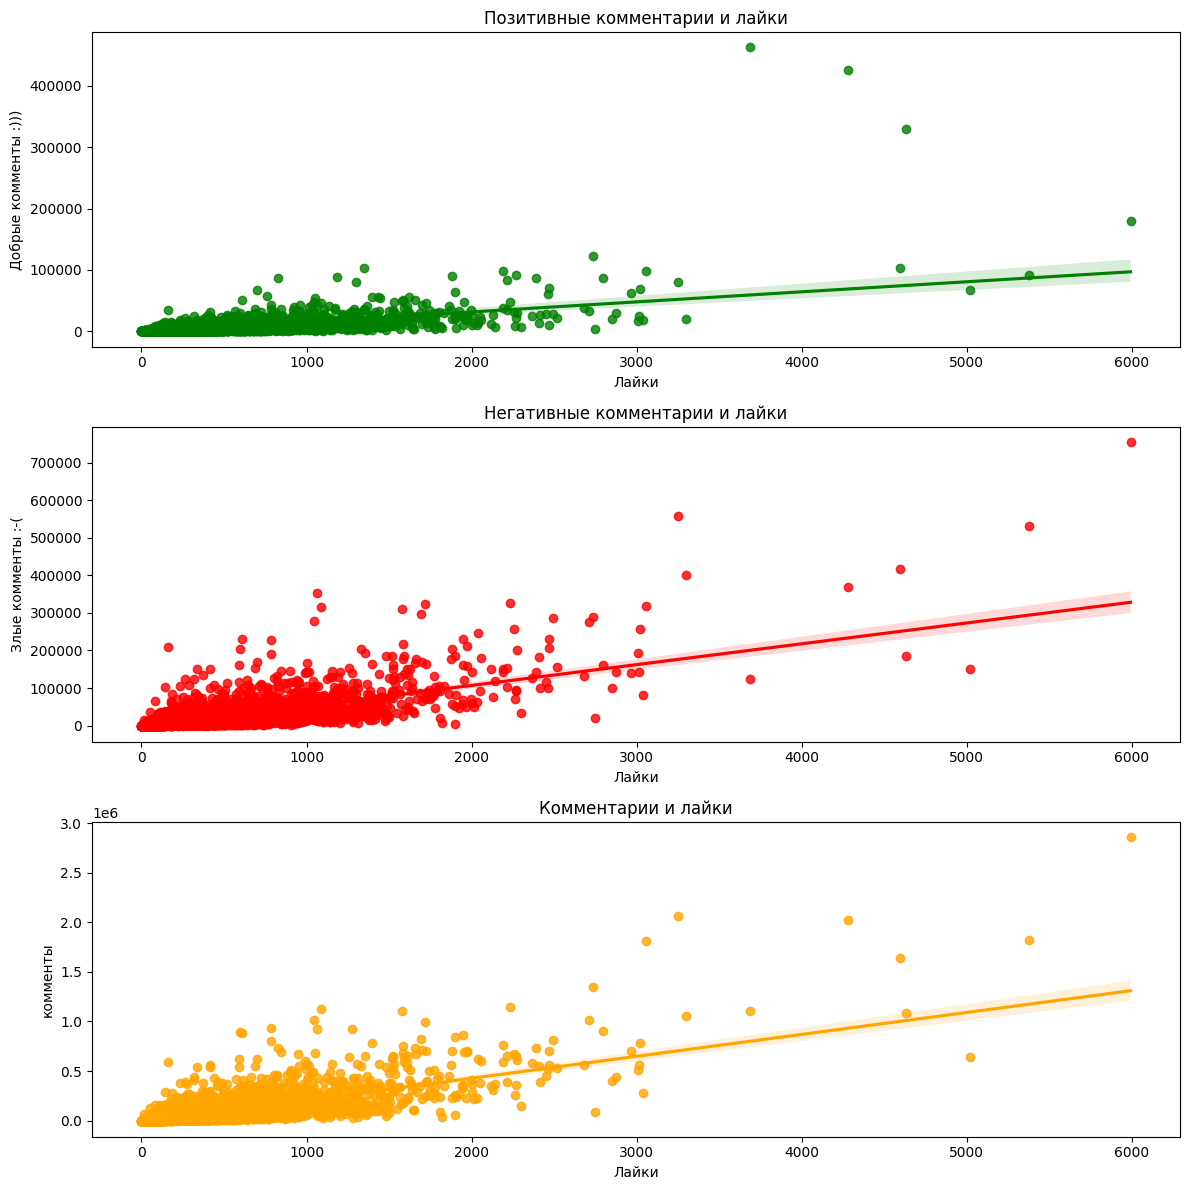

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(12, 12))


sns.regplot(data=dffz, x='likes', y='positive', ax=ax[0], color = 'green')
ax[0].set_title('Позитивные комментарии и лайки')
ax[0].set_xlabel('Лайки')
ax[0].set_ylabel('Добрые комменты :)))')


sns.regplot(data=dffz, x='likes', y='negative', ax=ax[1], color = 'red')
ax[1].set_title('Негативные комментарии и лайки')
ax[1].set_xlabel('Лайки')
ax[1].set_ylabel('Злые комменты :-(')


sns.regplot(data=dffz, x='likes', y='comms', ax=ax[2], color = 'orange')
ax[2].set_title('Комментарии и лайки')
ax[2].set_xlabel('Лайки')
ax[2].set_ylabel('комменты')



plt.tight_layout()
plt.show()


__[0.2]__  Давайте построим по сентимент-окрасу комментариев топ позитивных новостей.

- Если под новостью оставлено 100 комментариев, из которых 80 позитивные, мы можем быть уверены в том, что новость была хорошо воспринята людьми.
- Если под новостью всего один комментарий и он оказался позитивным, то у нас 100% позитивных комментариев, но это вовсе не означает, что новость была воспринята хорошо.

Получается, что сортировать по доле позитивных комментариев нельзя. Давайте поступим умнее. Доля позитивных комментариев под постом -- это случайная величина. Её довольно часто моделируют с помощью бета-распределения. Если это случайная величина, мы можем построить для неё предиктивный интервал. Пусть $u$ - число позитивных комментариев, а $d$ - нейтральных и негативных.  Пусть

$$
a = 1 + u \qquad b = 1 + d.
$$

Тогда нижняя граница $95\%$ предиктивного интервала для доли будет вычисляться по такой формуле:

$$
\frac{a}{a + b} - 1.65 \cdot \sqrt{\frac{a \cdot b}{(a + b)^2 \cdot (a + b + 1)}}
$$

Если под новостью был всего один комментарий, у такой случайной величины будет высокая дисперсия. Это означаen, что штука, которую мы вычитаем из доли, окажется высокой. Левая граница интервала окажется маленькой и мы не поднимем комментарий в нашем топе наверх. Фактически мы делаем сортировку по квантилю уровня $0.05$ вместо среднего.

От вас требуется вбить эту формулу, сделать сортировку и вывести на экран топ позитивных новостей. Подробнее про то, откуда берётся эта формула можно почитать [в этой книге.](https://disk.yandex.ru/i/Ctd08bTwC9eI3g) Ищите 4 главу, страницу 140.

In [ ]:
def sort_func_help(u, d):
    a = 1 + u
    b = 1 + d
    c = a / (a + b)
    d = (a * b / ((a + b) ** 2 * (a + b + 1))) ** 0.5
    return c - 1.65 * d

In [ ]:
dffz['sort_helper'] = dffz.apply(lambda x: sort_func_help(x['positive'], x['negative'] + x['neutral'] ), axis=1)

In [ ]:
dffz.head()

,likes,negative,neutral,positive,comms,sort_helper
post_id,,,,,,
17976037.0,154.0,12138,41650,2856,56644,0.048919
17976198.0,27.0,510,2040,51,2601,0.015453
17976601.0,77.0,737,3752,0,4489,-0.000145
17976766.0,62.0,528,1392,384,2304,0.154144
17976905.0,212.0,3360,8736,448,12544,0.033052


Построили? Срочно пришлите свою любимую позитивную  новость в общий чат!!!

Топ негативных новостей строить не будем. Вокруг итак слишком много негатива 😻😻😻

In [ ]:
dffz.sort_values(by = 'sort_helper', ascending=False ).head(10)

,likes,negative,neutral,positive,comms,sort_helper
post_id,,,,,,
22320852.0,135.0,0,800,1700,2500,0.664470
20128079.0,30.0,0,56,140,196,0.659162
22326485.0,21.0,0,56,140,196,0.659162
23489272.0,10.0,0,16,48,64,0.654274
20027260.0,45.0,0,192,384,576,0.633751
20591225.0,238.0,213,1846,2982,5041,0.580093
22783725.0,135.0,245,735,1421,2401,0.575220
20113362.0,14.0,0,96,160,256,0.574370
18238799.0,39.0,27,270,432,729,0.562371


In [ ]:
df_vk[[df_vk['id'] == 22320852.0]]

,id,href,datetime,title,likes,comments,snippet,title_clean,snippet_clean,target_tags
13735,20128079,https://rsport.ria.ru/artist_gym/20180323/1134...,2018-03-23 07:19:58,Россиянка Мельникова победила в многоборье на ...,670,17,#UNK#,россиянка мельникова победила в многоборье на ...,unk,[0]


__[0.2]__ Какие категории новостей оказались самыми позитивными? Придумайте способ найти такие категории и опишите его тут.

__Ответ:__

In [ ]:
rk = dffz.sort_values(by = 'sort_helper', ascending=False ).head(10)
rk

,likes,negative,neutral,positive,comms,sort_helper
post_id,,,,,,
22320852.0,135.0,0,800,1700,2500,0.664470
20128079.0,30.0,0,56,140,196,0.659162
22326485.0,21.0,0,56,140,196,0.659162
23489272.0,10.0,0,16,48,64,0.654274
20027260.0,45.0,0,192,384,576,0.633751
20591225.0,238.0,213,1846,2982,5041,0.580093
22783725.0,135.0,245,735,1421,2401,0.575220
20113362.0,14.0,0,96,160,256,0.574370
18238799.0,39.0,27,270,432,729,0.562371


In [ ]:
catt1 = df_vk[['id', 'title']]
catt1 = catt1.rename(columns={'id': 'post_id'})
# ٩(⁎❛ᴗ❛⁎)۶

In [ ]:
catt1

,post_id,title
0,24006362,"В ДНР заявили о задержании диверсантов, причас..."
1,24006240,"Житель Урала ""заминировал"" ТЦ из-за снятия со..."
2,24006100,"В Черном море нашли ""потерянный флот Гитлера"""
3,24005972,В США освободили задержанную российскую актрис...
4,24005764,Толкнувший Скабееву депутат Рады заявил о гроз...
...,...,...
19923,17976905,"Политологи назвали губернаторов, которым грози..."
19924,17976766,"Захарова рассказала, какую книгу подписывал Ла..."
19925,17976601,Современные люди появились более 300 тысяч лет...
19926,17976198,В США ребенок устроил стрельбу


In [ ]:
new = pd.merge(rk, catt1, on = 'post_id', how = 'left')

In [ ]:
new

,post_id,likes,negative,neutral,positive,comms,sort_helper,title
0,22320852.0,135.0,0,800,1700,2500,0.664470,Сборная России выиграла командный турнир на че...
1,20128079.0,30.0,0,56,140,196,0.659162,Россиянка Мельникова победила в многоборье на ...
2,22326485.0,21.0,0,56,140,196,0.659162,Россиянки заняли третье место в ските среди юн...
3,23489272.0,10.0,0,16,48,64,0.654274,"Ваши поздравления на елке ""Россия Сегодня"" в ГУМе"
4,20027260.0,45.0,0,192,384,576,0.633751,"Миленина выиграла биатлонную гонку на 12,5 км,..."
5,20591225.0,238.0,213,1846,2982,5041,0.580093,"""Ак Барс"" стал трехкратным обладателем Кубка Г..."
6,22783725.0,135.0,245,735,1421,2401,0.575220,Сборная России вернулась в Москву после победы...
7,20113362.0,14.0,0,96,160,256,0.574370,В Финляндии появился отель на лыжах
8,18238799.0,39.0,27,270,432,729,0.562371,Фигуристы Тарасова и Морозов победили в соревн...
9,23318180.0,43.0,54,243,432,729,0.562371,В Балашихе спасли провалившегося под лед ребенка


Топ 10 позитивных новостей -  различные события, связанные с разными видами спорта и событиями в мире.

Придумайте способ найти такие категории и опишите его тут.

Можно использовать те же трансформеры для классификации, предварительно обработав данные

__[0.2 бонусных]__ Проанализируйте, как температура комментария (вероятность того, что он негативный) зависит от длины трэда (число комментариев под новостью)? Значима ли эта взаимосвязь? Если вам для проверки этого хочется построить линейную регрессию, не сдерживайтесь.

In [ ]:
import statsmodels.api as sm # (https://stackoverflow.com/questions/27928275/find-p-value-significance-in-scikit-learn-linearregression) - статья помогла
dffz['neg_p'] = dffz['negative'] / dffz['comms']
X = dffz['comms']
y = dffz['neg_p']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  neg_p   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     434.0
Date:                Tue, 19 Dec 2023   Prob (F-statistic):           2.26e-95
Time:                        11:49:25   Log-Likelihood:                 20960.
No. Observations:               19927   AIC:                        -4.192e+04
Df Residuals:                   19925   BIC:                        -4.190e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1998      0.001    310.318      0.0

Cвязь между длиной треда и температурой комментария значима ***(P значение очень мало),*** однако между общим количеством комментариев и долей негативных комментариев слабая взаимосвязь ***(маленький коэффициент)***